## Gender classification task on human face images using Naive Bayes and logistic regression classifier. 


[Problem Statement](#section1)<br>
1. Download a dataset from https://github.com/StephenMilborrow/muct . Group the images into male and female categories based on the images. 
2. Randomly sample the face images to create a male and female face training sets consisting of 70% of the face images. Rest 30% face images form the face testing images. 
3. Build Naive Bayes classifier for male and female faces. Use intensity and SVD based features for these classifiers. 
4. Build a logistic regression based classifier for male and female faces. Use intensity and SVD based features for these classifiers. 
5. Calculate accuracy for the training set and testing set for the above classifiers, for both intensity and SVD based features and confusion matrix. 
6. Compare the performance of the above classifiers and report your observations. 


In [93]:
# importing necessary packages

import cv2
import numpy as np
import pandas as pd
import os 
from sklearn.model_selection import train_test_split,cross_val_score
import matplotlib.pyplot as plt
from imutils import face_utils

### Group the images into male and female categories based on the images

In [92]:
# getting the path:
basePath= os.path.dirname(os.getcwd())
imagesPath = basePath+"/faces/"

In [94]:
# defining empty list to hold rawImages , features and corresponding labels
rawImages = []
features = []
labels = []

In [95]:
# function to convert image to feature vector by resizing the images and flattening the matrix 

def image_to_feature_vector(image, size=(100, 100)):
    # resize the image to a fixed size, then flatten the image into
    # a list of raw pixel intensities
    return cv2.resize(image, size).flatten()

In [96]:
import imutils
def extract_color_histogram(image, bins=(8, 8, 8)):
    # extract a 3D color histogram from the HSV color space using
    # the supplied number of `bins` per channel
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0, 1, 2], None, bins,
        [0, 180, 0, 256, 0, 256])
    
    # handle normalizing the histogram if we are using OpenCV 2.4.X
    if imutils.is_cv2():
        hist = cv2.normalize(hist)
    
    # otherwise, perform "in place" normalization in OpenCV 3 (I
    # personally hate the way this is done
    else:
        cv2.normalize(hist, hist)
    
    # return the flattened histogram as the feature vector
    return hist.flatten()

In [97]:
# loop over the input images
import re
def prepare_all_data(imagesPath):
    dirs = os.listdir(imagesPath)
    for i in dirs:
        # load the image and extract the class label (assuming that our
        # path as the format: /path/to/dataset/{class}.{image_num}.jpg
        image = cv2.imread(imagesPath+i)
        extractLabel = (re.split("-",i)[-1]).split(".",1)[0]
        if(extractLabel.startswith('m')):
            label="male"
        else:
            label="female"
    
        # extract raw pixel intensity "features", followed by a color
        # histogram to characterize the color distribution of the pixels
        # in the image
        pixels = image_to_feature_vector(image)
        hist = extract_color_histogram(image)
    
        # update the raw images, features, and labels matricies,
        # respectively
        rawImages.append(pixels)
        features.append(hist)
        labels.append(label)
    
        

In [98]:
prepare_all_data(imagesPath)

#### Holding Raw Images and features in array 

In [99]:
rawImages = np.array(rawImages)
features = np.array(features)
labels = np.array(labels)
print("[INFO] pixels matrix: {:.2f}MB".format(
    rawImages.nbytes / (1024 * 1000.0)))
print("[INFO] features matrix: {:.2f}MB".format(
    features.nbytes / (1024 * 1000.0)))

[INFO] pixels matrix: 22.00MB
[INFO] features matrix: 1.50MB


#### Splitting Raw Images and feature Vectors in train test split

#### Randomly sample the face images to create a male and female face training sets consisting of 75% of the face images. Rest 25% face images form the face testing images. 

In [85]:
(trainRI, testRI, trainRL, testRL) = train_test_split(
    rawImages, labels, test_size=0.25, random_state=42)
(trainFeat, testFeat, trainLabels, testLabels) = train_test_split(
    features, labels, test_size=0.25, random_state=42)



### Build Naive Bayes classifier for male and female faces. Use intensity and SVD based features for these classifiers.

#### Naive Bayes using SVD on the Raw Images Matrix

In [139]:
## Using SVD to reduce the dimensions of the vectors 
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=511)
svd.fit(trainRI)
new_train=svd.transform(trainRI) 

In [102]:
## fit the transformed train images on the GaussianNB

from sklearn.naive_bayes import GaussianNB
#Create a Gaussian Classifier
model_GNB = GaussianNB()
model_GNB.fit(new_train,trainRL)

GaussianNB(priors=None, var_smoothing=1e-09)

In [104]:
# Transform the Raw Images on the test using SVD
new_test=svd.transform(testRI) 

In [103]:
## get the shape of transformed test images and labels
new_test.shape,testRL.shape

((188, 511), (188,))

#### Getting the accuracy of the scores on the raw Images features 

In [109]:
score=model_GNB.score(new_test,testRL)
print("[INFO] Raw pixel accuracy: {:.2f}%".format(score * 100))

[INFO] Raw pixel accuracy: 72.34%


In [124]:
predictedRaw = model_GNB.predict(new_test)

In [128]:
predRawCnt=0
for i in range(len(testRL)):
    if(testRL[i]==predictedRaw[i]):
        predRawCnt+=1
print("Raw pixel Actual values Count: ",(len(testRL)))
print("Raw pixel Predicted values: ",(predRawCnt))

Raw pixel Actual values Count:  188
Raw pixel Predicted values:  136


### male and female count in Actual test data

In [162]:
count_f=0
count_m=0
for i in range(len(testRL)):
    if(testRL[i]=='male'):
        count_m=count_m+1
    else:
        count_f=count_f+1
print("Actual Male Count in test Data:",count_m)
print("Actual FeMale Count in test Data:",count_f)



Actual Male Count in test Data: 88
Actual FeMale Count in test Data: 100


## Confusion Matrix for the Naive bayes classifier

[[77 23]
 [29 59]]


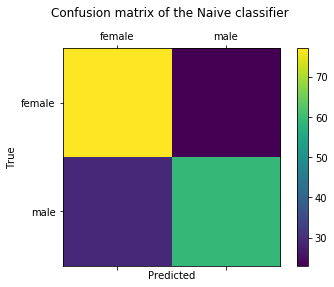

In [164]:
from sklearn.metrics import confusion_matrix

labels = ['female', 'male']
cm_logistic = metrics.confusion_matrix(testRL, predictedRaw)
print(cm_logistic)

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm_logistic)
plt.title('Confusion matrix of the Naive classifier \n')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [129]:
###########################################################################

#### Naive Bayes using SVD on the feature Matrix 

In [130]:
## Using SVD to reduce the dimensions of the feature vectors  


from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=511)
svd.fit(trainFeat)
new_train_feat=svd.transform(trainFeat) 

In [131]:
## Fitting Naive bayes on the feature vectors using Gaussian Classifier

from sklearn.naive_bayes import GaussianNB
#Create a Gaussian Classifier
model_GNB_feat = GaussianNB()
model_GNB_feat.fit(new_train_feat,trainLabels)

GaussianNB(priors=None, var_smoothing=1e-09)

In [132]:
# Transform the feature vectors  on the test using SVD
new_test_feat=svd.transform(testFeat) 

In [133]:
score=model_GNB.score(new_test_feat,testLabels)
print("[INFO] Feature Matrix accuracy: {:.2f}%".format(score * 100))

[INFO] Feature Matrix accuracy: 46.81%


### Note:: Since the feature matrix vector accuray is not good so we can discard the feature Matrix vectors

<h1><center> Build a logistic regression based classifier for male and female faces. 
              
              Use intensity and SVD based features for these classifiers!</center></h1>

In [135]:
from sklearn.linear_model import LogisticRegression

In [140]:
logisticRegr = LogisticRegression()
logisticRegr.fit(new_train,trainRL)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

#### Getting the accuracy of the scores on the raw Images features

In [141]:
score=logisticRegr.score(new_test,testRL)
print("[INFO] Raw pixel accuracy: {:.2f}%".format(score * 100))

[INFO] Raw pixel accuracy: 90.43%


In [142]:
predictedLogRaw = logisticRegr.predict(new_test)

### male and female count in Actual test data 

In [160]:
count_f=0
count_m=0
for i in range(len(testRL)):
    if(testRL[i]=='male'):
        count_m=count_m+1
    else:
        count_f=count_f+1
print("Actual Male Count in test Data:",count_m)
print("Actual FeMale Count in test Data:",count_f)


Actual Male Count in test Data: 88
Actual FeMale Count in test Data: 100


## Confusion Matrix for the Logistic based classifier 

[[98  2]
 [16 72]]


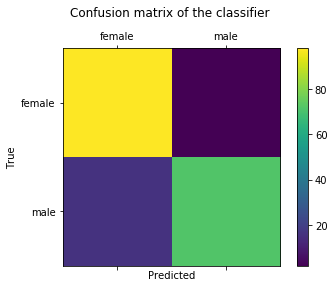

In [161]:
from sklearn.metrics import confusion_matrix

labels = ['female', 'male']
cm_logistic = metrics.confusion_matrix(testRL, predictedLogRaw)
print(cm_logistic)

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm_logistic)
plt.title('Confusion matrix of the classifier \n')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()